In [2]:
!pip install diffusers transformers accelerate torch torchvision


   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.1 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.5/4.1 MB 670.4 kB/s eta 0:00:06
   ------- -------------------------------- 0.8/4.1 MB 745.8 kB/s eta 0:00:05
   ------- -------------------------------- 0.8/4.1 MB 745.8 kB/s eta 0:00:05
   ---------- ----------------------------- 1.0/4.1 MB 709.1 kB/s eta 0:00:05
   ---------- ----------------------------- 1.0/4.1 MB 709.1 kB/s eta 0:00:05
   ------------ --------------------------- 1.3/4.1 MB 721.7 kB/s eta 0:00:04
   --------------- ------------------------ 1.6/4.1 MB 755.9 kB/s eta 0:00:04
   --------------- ---------------------

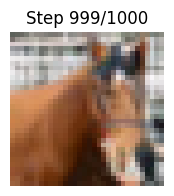

In [8]:
from diffusers import DDPMPipeline
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# -----------------------------
# 1. Load pipeline
# -----------------------------
model_id = "google/ddpm-cifar10-32"
pipe = DDPMPipeline.from_pretrained(model_id)
pipe.to("cuda" if torch.cuda.is_available() else "cpu")
device = pipe.device

# -----------------------------
# 2. Set number of steps
# -----------------------------
num_inference_steps = 1000   # or e.g. 250
pipe.scheduler.set_timesteps(num_inference_steps)

# start from pure noise
x = torch.randn(1, 3, 32, 32, device=device)

# -----------------------------
# 3. Sampling loop with visualization
# -----------------------------
for i, t in enumerate(pipe.scheduler.timesteps):
    with torch.no_grad():
        noise_pred = pipe.unet(x, t).sample

    x = pipe.scheduler.step(noise_pred, t, x).prev_sample

    # visualize every 100 steps (and at the last one)
    if (i % 100 == 0) or (i == len(pipe.scheduler.timesteps) - 1):
        img = (x.clamp(-1, 1) + 1) / 2.0   # [-1,1] -> [0,1]
        grid = make_grid(img, nrow=1)

        np_img = grid.permute(1, 2, 0).detach().cpu().numpy()

        clear_output(wait=True)           # replace previous plot
        plt.figure(figsize=(2, 2))
        plt.imshow(np_img)
        plt.axis("off")
        plt.title(f"Step {i}/{num_inference_steps}")
        display(plt.gcf())
        plt.close()

# x now contains the final sample
